In [1]:
import pandas as pd
import numpy as np
import xgboost
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score,classification_report
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

In [2]:
df = pd.read_csv("trip_records_acs_50.csv")

df.shape

(90798, 117)

In [3]:
df.dropna(inplace=True)
df.shape

(90798, 117)

In [4]:
df.columns

Index(['Unnamed: 0', 'Trip ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area',
       ...
       'hour_temp', 'hour_wind', 'hour_prec', 'ave_solo_secs',
       'ave_solo_miles', 'ave_solo_fare', 'distance_haversine',
       'distance_manhattan', 'pick_dist_dt', 'drop_dist_dt'],
      dtype='object', length=117)

In [5]:
df['rain'] = pd.cut(df.hour_prec, [-np.inf, 0.01, 0.1, 0.3, 2, +np.inf] , labels = [0,1,2,3,4]).astype(int)

In [6]:
df['angle'] = np.degrees(np.arctan2((df['drop_lat'] - df['pick_lat']),(df['drop_long'] - df['pick_long'])))

df['ln_pop_den_x'] = (np.log(df['total_pop_x']/df['area_upr_x']))
df['ln_pop_den_y'] = (np.log(df['total_pop_y']/df['area_upr_y']))

df['pct_non_white_x'] = 100 - df['pct_white_x']
df['pct_non_white_y'] = 100 - df['pct_white_y']


In [10]:
df.groupby(['shared']).describe() [['detour_time','detour_dist','discount_fare']]

detour_time                                                        \
             count       mean        std        min       25%        50%   
shared                                                                     
False      45399.0  -0.021715  13.423524 -75.744976  0.000000   0.000000   
True       45399.0  27.211268  51.825246 -90.318725 -8.195782  17.905918   

                              detour_dist             ...             \
              75%         max       count       mean  ...        75%   
shared                                                ...              
False    0.000000  375.373740     45399.0  -0.022537  ...   0.000000   
True    51.988761  754.067797     45399.0  23.791650  ...  33.333333   

                    discount_fare                                         \
                max         count       mean        std         min  25%   
shared                                                                     
False    651.412429       45399.0  -0.018497  14.697072 -412.195122  0.0   
True    1996.883679       45399.0  21.224428  40.278097 -400.000000  0.0   

                               
         50%   75%        max  
shared                         
False    0.0   0.0  80.487805  
True    25.0  50.0  95.833333  

[2 rows x 24 columns]

In [11]:
df.describe()

,Unnamed: 0,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tip,Additional Charges,...,drop_dist_dt,rain,angle,ln_pop_den_x,ln_pop_den_y,pct_non_white_x,pct_non_white_y,detour_time,detour_dist,discount_fare
count,9.079800e+04,90798.000000,90798.000000,9.079800e+04,9.079800e+04,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,...,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000
mean,5.188257e+05,960.699233,3.660647,1.703136e+10,1.703137e+10,20.515221,20.898830,8.024984,0.365790,1.963118,...,4.116219,0.073085,6.655167,0.059654,-0.058239,31.250091,31.100470,13.594777,11.884556,10.602966
std,3.208000e+05,487.211424,2.593140,3.182477e+05,3.209060e+05,13.599324,13.543904,4.456213,1.033093,1.306997,...,3.476295,0.329386,101.620333,2.954568,2.937431,17.484108,17.929409,40.229575,55.388236,32.124307
min,3.000000e+00,300.000000,1.000149,1.703101e+10,1.703101e+10,1.000000,1.000000,2.500000,0.000000,0.000000,...,0.270467,0.000000,-179.978269,-7.823321,-7.823321,3.800000,3.300000,-90.318725,-97.649573,-412.195122
25%,2.511730e+05,607.000000,1.833072,1.703108e+10,1.703108e+10,8.000000,8.000000,5.000000,0.000000,0.720000,...,1.751322,0.000000,-74.974956,-2.132575,-2.132575,18.300000,18.200000,-1.361106,-2.777778,0.000000
50%,4.809205e+05,849.000000,2.900000,1.703124e+10,1.703128e+10,24.000000,24.000000,7.500000,0.000000,2.550000,...,2.807029,0.000000,-0.465006,-0.393609,-0.395820,26.700000,26.700000,0.000000,0.000000,0.000000
75%,7.797340e+05,1192.000000,4.700000,1.703183e+10,1.703183e+10,32.000000,32.000000,10.000000,0.000000,2.550000,...,6.099515,0.000000,104.333143,3.299313,2.988054,39.900000,39.900000,22.815396,12.820513,30.434783
max,1.179065e+06,7180.000000,47.900000,1.703184e+10,1.703184e+10,77.000000,77.000000,75.000000,30.000000,15.100000,...,27.122667,3.000000,179.993069,4.592161,4.592161,100.000000,100.000000,754.067797,1996.883679,95.833333


In [32]:
X = df[['Trip Miles','Trip Seconds', 'angle', 'discount_fare',
        
        
        'start_dayweek', 'month', 'hour', 
        
        'hour_temp', 'hour_wind', 'rain',
        
        'metro_x','pick_dist_dt','drop_dist_dt', 'ln_pop_den_x', 'ln_pop_den_y',
       
       'pct_bach_x', 'median_income_x', 'sex_ratio_x',
        
       'pct_non_white_x', 'pct_age_18_29_x', 'pct_no_car_x',

       #'pct_bach_y', 'median_income_y', 'ln_total_pop_y', 'sex_ratio_y',
       #'pct_non_white_y', 'median_age_y', 'pct_no_car_y', 'pct_unemp_y',
       
       'residential_den_x' , 'empoloyment_den_x','job_entropy_x',
        'dist_to_tran_x', 'walkability_x',
        
       #'residential_den_y' , 'empoloyment_den_y',
       #'job_entropy_y', 'dist_to_tran_y', 'walkability_y',
        
        'pick_long','pick_lat','drop_long','drop_lat',
        
       ]]


In [33]:
df.groupby(['shared']).mean().reset_index()['Trip Miles']

0    3.803343
1    3.517951
Name: Trip Miles, dtype: float64

array([[<AxesSubplot:title={'center':'Trip Miles'}>,
        <AxesSubplot:title={'center':'Trip Seconds'}>,
        <AxesSubplot:title={'center':'angle'}>,
        <AxesSubplot:title={'center':'start_dayweek'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'metro_x'}>,
        <AxesSubplot:title={'center':'discount_fare'}>,
        <AxesSubplot:title={'center':'hour_temp'}>,
        <AxesSubplot:title={'center':'hour_wind'}>,
        <AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'pick_dist_dt'}>],
       [<AxesSubplot:title={'center':'drop_dist_dt'}>,
        <AxesSubplot:title={'center':'ln_pop_den_x'}>,
        <AxesSubplot:title={'center':'ln_pop_den_y'}>,
        <AxesSubplot:title={'center':'pct_bach_x'}>,
        <AxesSubplot:title={'center':'median_income_x'}>,
        <AxesSubplot:title={'center':'sex_ratio_x'}>],
       [<AxesSubplot:title={'center':'pct_non_wh

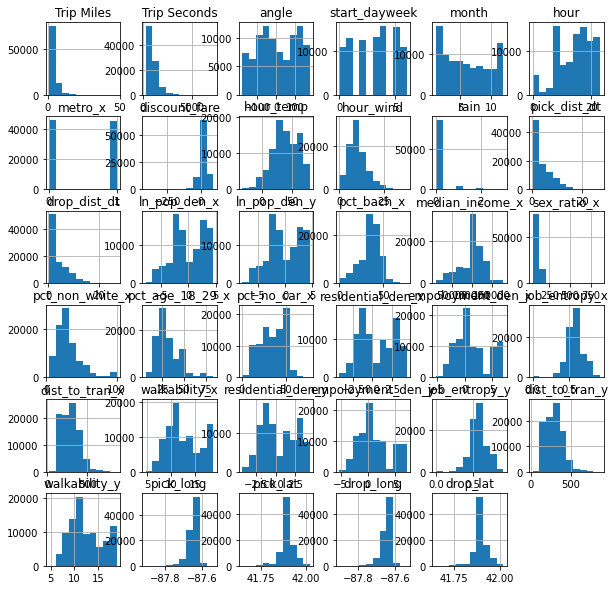

In [34]:
X.hist(figsize=(10,10))

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df["shared"], 
                                                    test_size = 0.2, 
                                                    random_state = 0)


d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [36]:
im = (y_train==False).sum() / (y_train==True).sum()
print(im)

1.0020947603428791


## Hyper-parameter tuning

In [37]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 16, 1, dtype=int)),
        #'n_estimators':hp.choice('n_estimators', np.arange(40, 2001, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.05),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 16, 1, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.4, 1.01, 0.05),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.02, 0.6, 0.02)),
        'gamma': hp.quniform('gamma', 0, 3, 0.05),

        'objective':'binary:logistic',
        'tree_method' : 'hist',
        'eval_metric': 'logloss',
    }


def inner_cv(X_temp, y_temp,n_evals=1000):
    
    def score(params, n_folds=5):
    
        #Cross-validation
        d_train = xgboost.DMatrix(X_temp,y_temp)
    
        cv_results = xgboost.cv(params, d_train, nfold = n_folds,num_boost_round=500,
                        early_stopping_rounds = 10, metrics = 'logloss', seed = 0)
        
        loss = min(cv_results['test-logloss-mean'])
        return loss


    def optimize(trials, space):
    
        best = fmin(score, space, algo=tpe.suggest, max_evals=n_evals,
                rstate=np.random.RandomState(333))#Add seed to fmin function
        return best

    trials = Trials()
    best_params = optimize(trials, space)

    # Return the best parameters
    best_params = space_eval(space, best_params)

    print(best_params)
    return best_params


In [38]:
%%time

best_params = inner_cv(X_train, y_train, n_evals=10)

100%|██████████| 10/10 [02:18<00:00, 13.86s/trial, best loss: 0.33507499999999996]
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'logloss', 'gamma': 2.6500000000000004, 'learning_rate': 0.04, 'max_depth': 14, 'min_child_weight': 10, 'objective': 'binary:logistic', 'subsample': 1.0, 'tree_method': 'hist'}
CPU times: user 13min 43s, sys: 31.4 s, total: 14min 14s
Wall time: 2min 18s


In [39]:
evals_result = {}

model = xgboost.train(best_params, d_train, num_boost_round=300, evals = [(d_train,"train"),(d_test, "test")], 
                      verbose_eval=50, early_stopping_rounds=10,evals_result=evals_result)


[0]	train-logloss:0.67218	test-logloss:0.67317
[50]	train-logloss:0.34250	test-logloss:0.38482
[100]	train-logloss:0.27631	test-logloss:0.34767
[150]	train-logloss:0.24838	test-logloss:0.33842
[200]	train-logloss:0.23247	test-logloss:0.33385
[250]	train-logloss:0.21848	test-logloss:0.33086
[300]	train-logloss:0.20786	test-logloss:0.32884
[350]	train-logloss:0.19794	test-logloss:0.32807
[400]	train-logloss:0.19008	test-logloss:0.32728
[417]	train-logloss:0.18776	test-logloss:0.32729


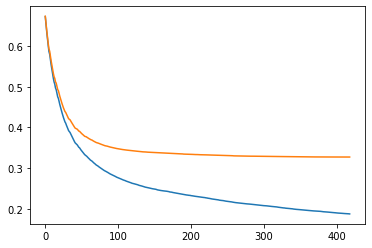

In [40]:
plt.plot(evals_result['train']['logloss'])
plt.plot(evals_result['test']['logloss'])

In [41]:
y_pred = model.predict(d_test)
y_pred_class = (y_pred > 0.50)
acc_xgb = (y_pred_class == y_test.values).sum().astype(float) / len(y_pred_class)*100

print(acc_xgb)

85.24229074889867


<AxesSubplot:>

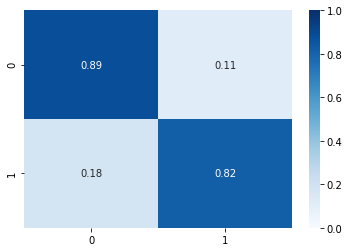

In [42]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_class,normalize='true'),
            
            vmin=0,vmax=1,cmap='Blues',annot=True)

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
logit_roc_auc = roc_auc_score(y_test, y_pred_class) 
print(logit_roc_auc)

0.8525613622742427


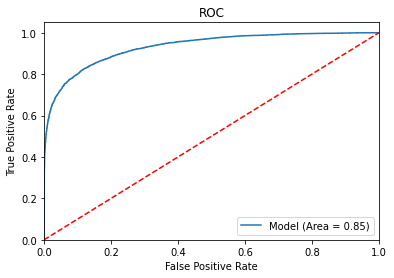

In [44]:
plt.figure()
plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')

In [45]:
%%time

X_sample = X.sample(50000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

CPU times: user 36min 24s, sys: 13.7 s, total: 36min 38s
Wall time: 5min 35s


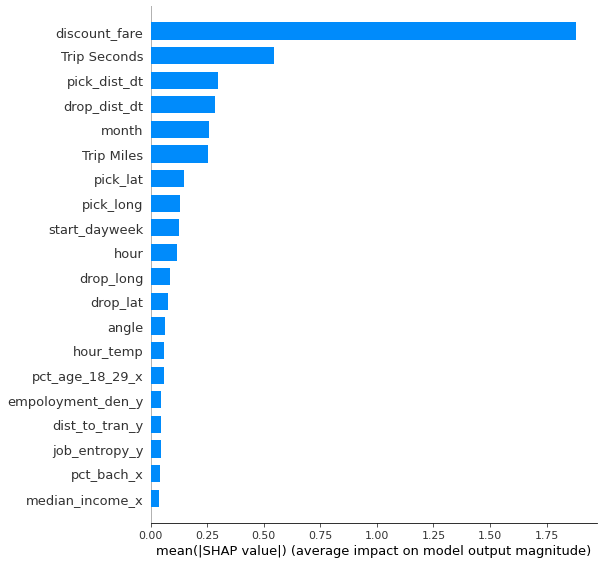

In [46]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

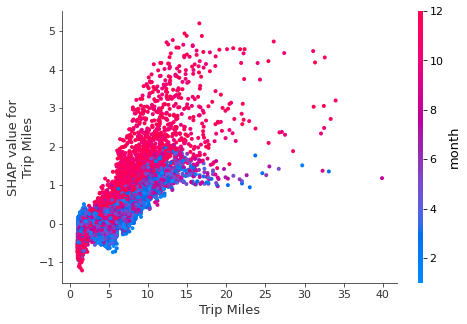

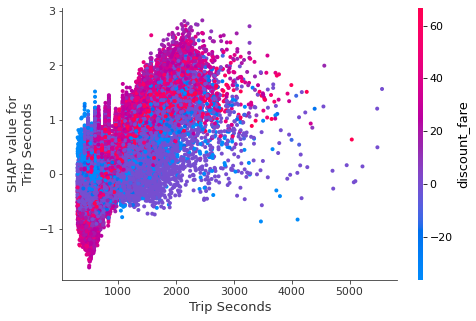

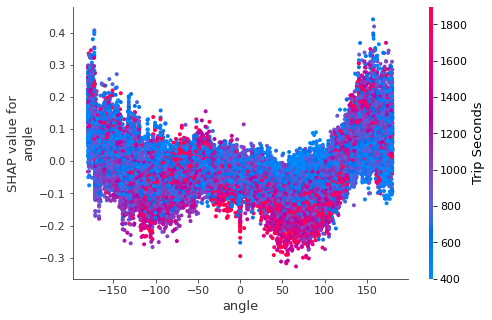

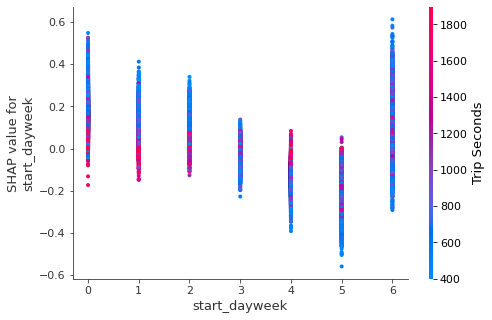

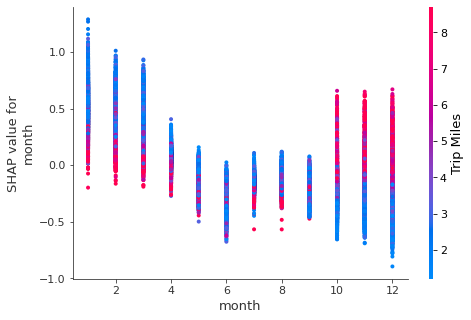

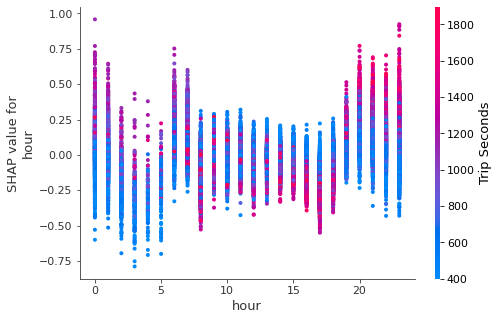

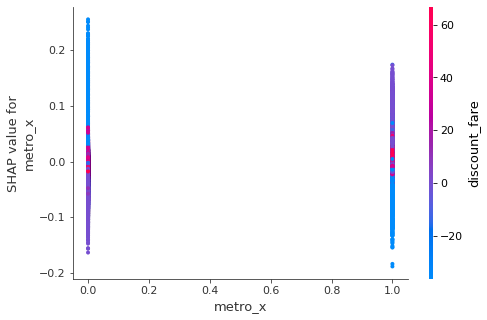

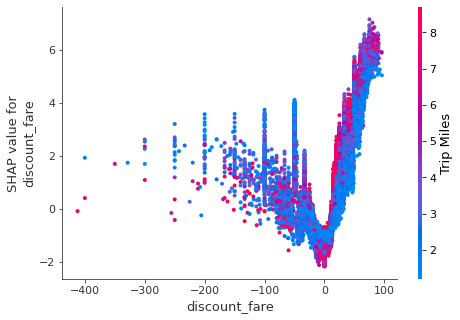

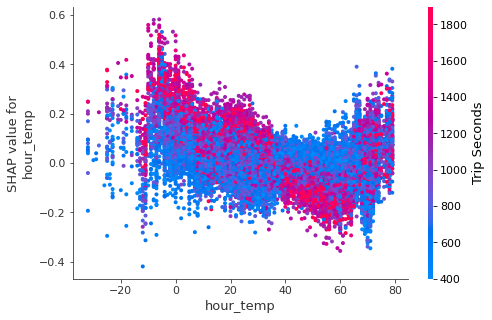

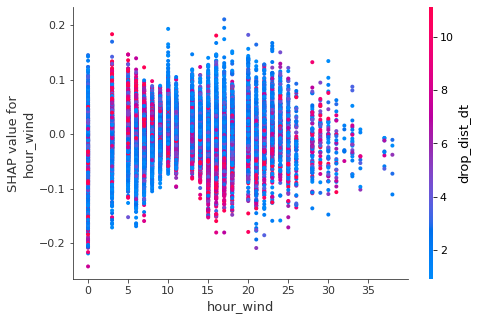

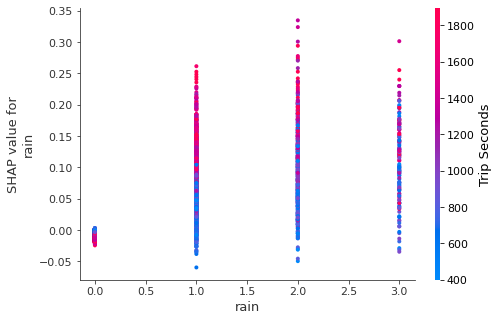

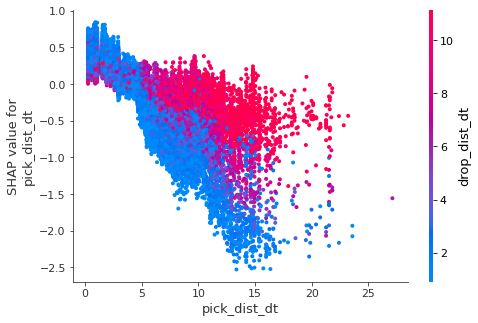

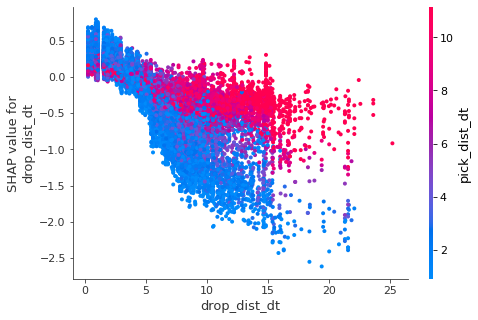

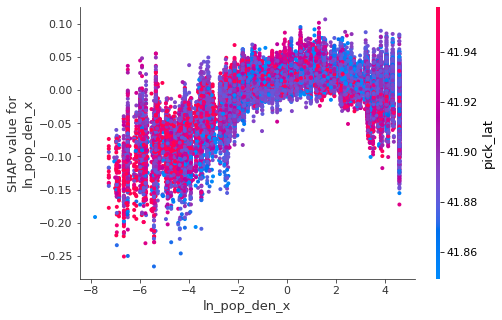

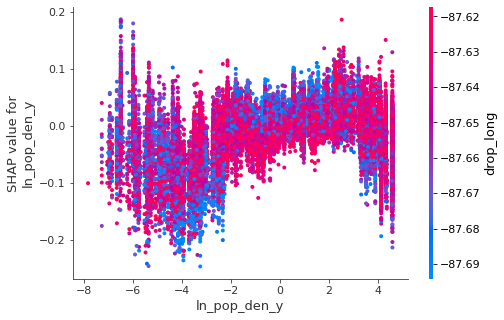

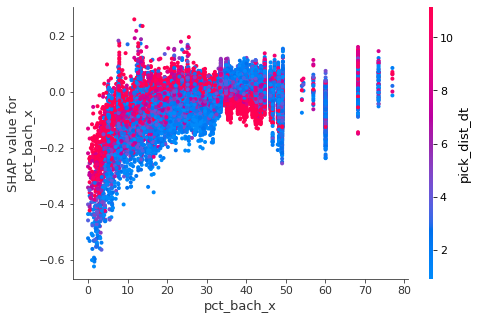

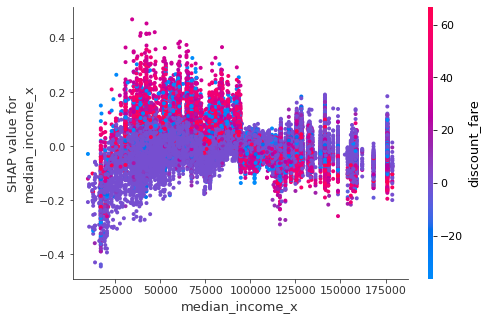

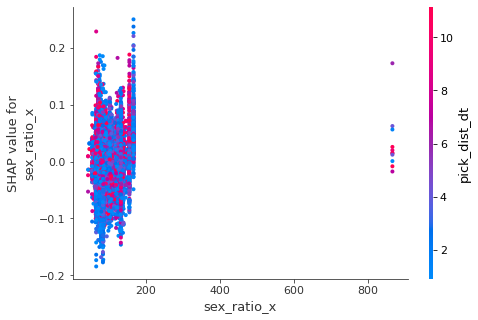

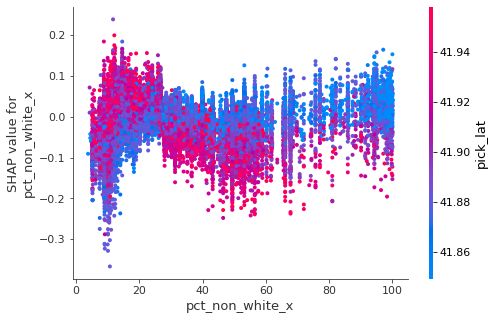

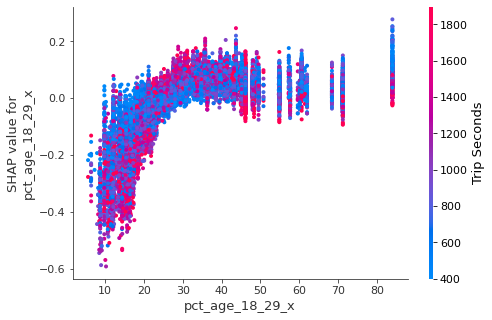

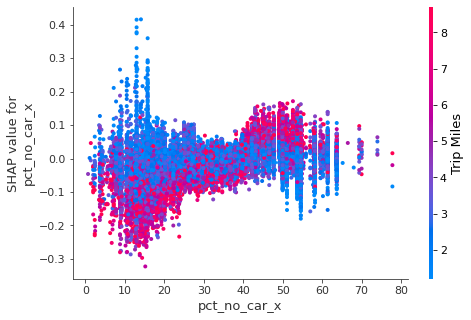

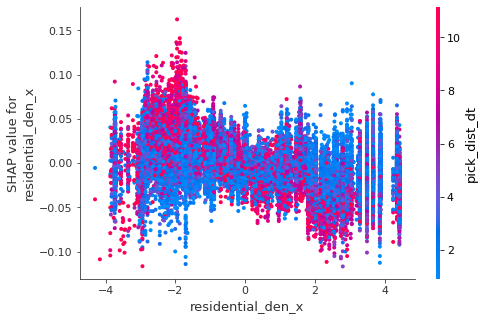

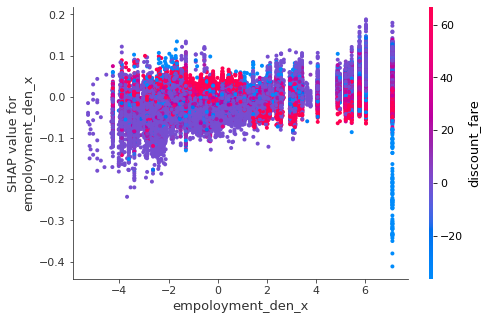

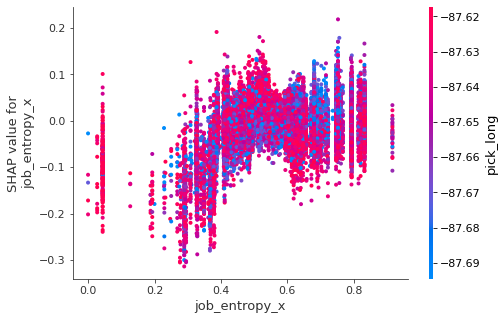

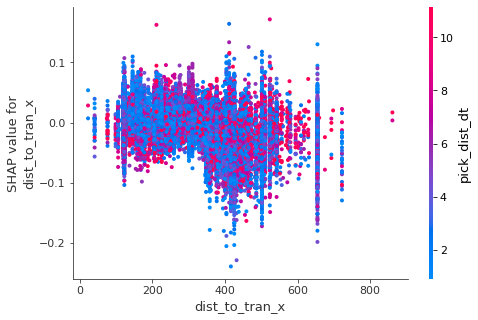

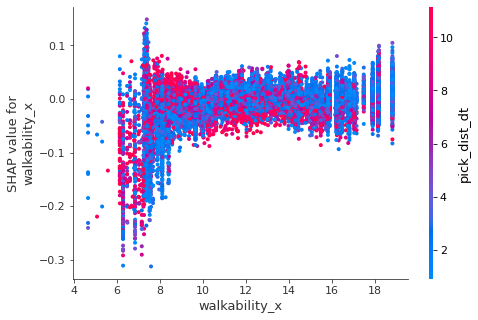

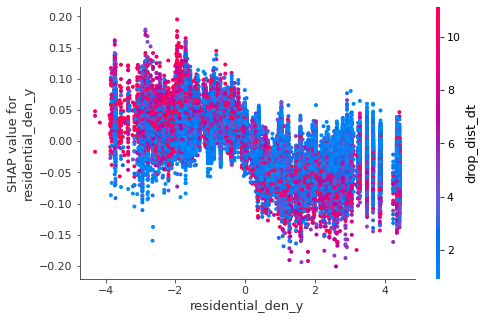

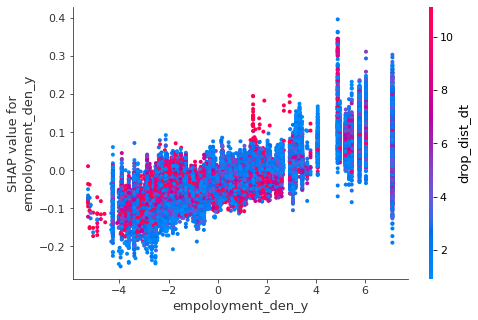

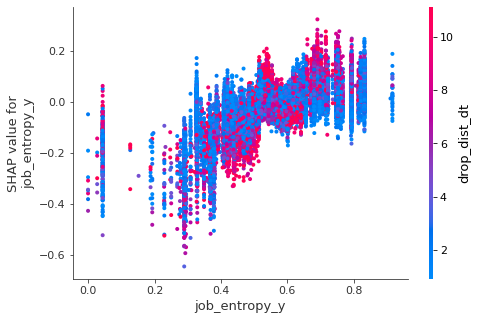

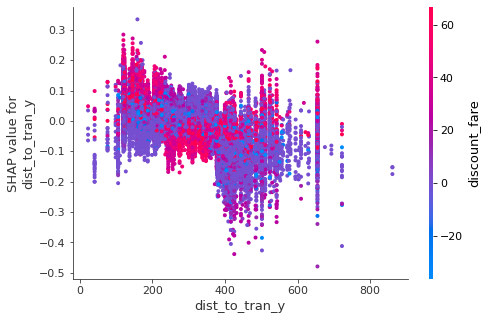

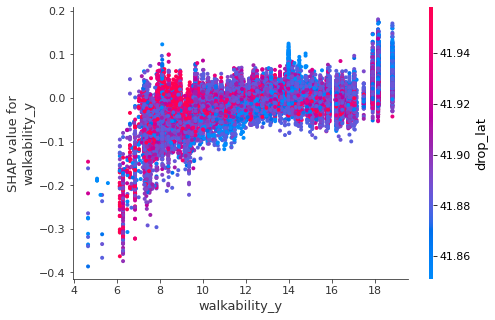

In [47]:
for name in X_sample.columns[:-4]:
    shap.dependence_plot(name, shap_values,X_sample)

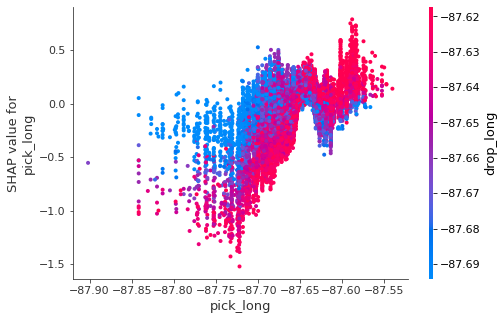

In [48]:
shap.dependence_plot('pick_long', shap_values,X_sample)